In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-08-09 18:26:04.375722: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-08-09 18:26:04.419275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:d8:00.0
2024-08-09 18:26:04.419634: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-08-09 18:26:04.422046: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-08-09 18:26:04.423731: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-08-09 18:26:04.424116: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-08-09 18:26:04.426324: I tensorflow/stream_executor

In [3]:
#Reading files into a log
import sys
import logging

nblog = open("nb_mtl.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [3]:
class ConvScaleShift(keras.layers.Layer):
    def __init__(self, channels, filters, kernel_size, trable = False, conv_trable = False, **kwargs):
        super(ConvScaleShift, self).__init__(**kwargs)
        self.conv = layers.Conv2D(filters, kernel_size, padding='same', trainable=conv_trable)

        self.shift = self.add_weight(name='shift', shape=(filters), 
                                     initializer='zeros', trainable=True)
        self.scale = self.add_weight(name='scale', shape=(1, 1, channels, filters), 
                                     initializer='ones', trainable=True)
        self.trable = trable
        self.act = keras.activations.relu
        self.conv_trable = conv_trable
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'shift': self.shift,
            'scale': self.scale,
            'trable': self.trable,
            'act': self.act,
        })
        return config
        
    # Defines the computation
    def call(self, inputs):
        if self.trable == False:
            x = self.conv(inputs)
            x = self.act(x)
            return x
        else:
            y = self.conv(inputs)
            oldw = self.non_trainable_weights[-2]
            oldb = self.non_trainable_weights[-1]
            neww = tf.multiply(oldw, self.scale) 
            newb = tf.add(oldb, self.shift)
            x = tf.nn.conv2d(inputs, neww, strides = 1, padding='SAME') + newb            
            x = self.act(x)
            return x

In [6]:
#Defining the CWoLA model
def CWoLA(p_i, trable = False, conv_trable = False):
    
    input_1 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_1")
    y = keras.layers.BatchNormalization()(input_1)
    input_2 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_2")
    z = keras.layers.BatchNormalization()(input_2)
    
    cnn = keras.Sequential([
        ConvScaleShift(1 , 64, (5,5), trable = trable, conv_trable = conv_trable),
        keras.layers.MaxPool2D(pool_size = (2,2), trainable = conv_trable),
        ConvScaleShift(64, 64, (5,5), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2), trainable = conv_trable),
        ConvScaleShift(64, 128, (3,3), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2)),    
        ConvScaleShift(128, 128, (3,3), trable = trable, conv_trable = conv_trable),
        keras.layers.Flatten(),
    ])
        
    dnn = keras.Sequential([
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    x_1 = dnn(cnn(y))
    x_2 = dnn(cnn(z))
    
    x = keras.layers.Multiply()([x_1, x_2])
    
    return keras.Model(         
    inputs=[input_1, input_2],
    outputs=x,)

In [5]:
def data_extraction(s1, s2, bkg_sr_jet_1, bkg_sr_jet_2, mv_idx, mv_idx_bkg, n_train_sr_signal, rng):
    signal_train_1 = s1[(mv_idx-1)*n_train_sr_signal:mv_idx*n_train_sr_signal]
    signal_train_2 = s2[(mv_idx-1)*n_train_sr_signal:mv_idx*n_train_sr_signal]
    signal_train_label = np.ones(np.shape(signal_train_1)[0], dtype = int)
    
    bkg_train_1 = bkg_sr_jet_1[(mv_idx_bkg-1)*n_train_sr_signal:mv_idx_bkg*n_train_sr_signal]
    bkg_train_2 = bkg_sr_jet_2[(mv_idx_bkg-1)*n_train_sr_signal:mv_idx_bkg*n_train_sr_signal]
    bkg_train_label = np.zeros(np.shape(bkg_train_1)[0], dtype = int)
    
    x_train_1 = np.concatenate((signal_train_1, bkg_train_1))
    x_train_2 = np.concatenate((signal_train_2, bkg_train_2))
    y_train = np.concatenate((signal_train_label, bkg_train_label))
    
    indices_2 = rng.permutation(np.shape(y_train)[0])
    
    x_train_1 = x_train_1[indices_2]
    x_train_2 = x_train_2[indices_2]
    y_train = y_train[indices_2]
    
    x_train_1 = x_train_1.reshape(np.shape(x_train_1)[0], p_1, p_1, 1)
    x_train_2 = x_train_2.reshape(np.shape(x_train_1)[0], p_1, p_1, 1)
    
    return x_train_1, x_train_2, y_train

In [6]:
%%capture
n_train_sr_bkg = 2500 
n_train_sr_signal = 2500
patience_number = 20
meta_tasks = ['id1', 'id5', 'id20', 'id30', 'id40', 'id50', 'dd1', 'dd5', 'id10', 'dd20', 
              'dd30', 'dd40', 'dd50']
loss_object = keras.losses.BinaryCrossentropy()
gamma = 1e-4 #Meta learner update rate
beta = 1e-3 #Base learning rate
optimizer_bl = keras.optimizers.Adam(learning_rate = beta)
optimizer_mtl = keras.optimizers.Adam(learning_rate = gamma)
rng = np.random.default_rng(seed=44)

for p_1 in [50]:#[25, 50, 75]:
    os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')
    bkg_sr_jet_1 = np.load(f'/home/manhducnmd/pp_dijet/Results_full/mtl_background_images_sr_{p_1}_jet_1.npy')
    bkg_sr_jet_2 = np.load(f'/home/manhducnmd/pp_dijet/Results_full/mtl_background_images_sr_{p_1}_jet_2.npy')
    bl_model = CWoLA(p_1, trable = False, conv_trable = False) #Base learning model can't be trained upon the shifting and scaling params
    bl_model.load_weights(f'/home/manhducnmd/pp_dijet/Model_results/weights_pt_dd10_{p_1}')
    bl_model.compile(loss = loss_object, optimizer = optimizer_bl, metrics = ['accuracy'])
    average_loss_all = []
    average_accuracy_all = []
    count_patience = 0
    best_model = CWoLA(p_1, trable = False, conv_trable = False) #Best model for patience training
    mv_idx_bkg_array = 1 + np.arange(len(meta_tasks))*3 #Moving index in order to make sure we sample new data
    for meta_epoch in range(100):
        idx_shuffle = rng.permutation(len(meta_tasks))
        meta_tasks_shuffle = np.array(meta_tasks)[idx_shuffle]
        mv_idx_bkg_array_shuffle = mv_idx_bkg_array[idx_shuffle]
        loss_total = 0
        accuracy_total = 0
        for idx_meta_task, meta_task in enumerate(meta_tasks_shuffle):
            mv_idx = 1
            mv_idx_bkg = mv_idx_bkg_array_shuffle[idx_meta_task]
            #Preparing the data
            
            s1 = np.load(f'/home/manhducnmd/pp_dijet/Results_full/m_{meta_task}_sr_{p_1}_jet_1.npy', 
                         mmap_mode = 'r')[10000:]
            s2 = np.load(f'/home/manhducnmd/pp_dijet/Results_full/m_{meta_task}_sr_{p_1}_jet_2.npy',
                        mmap_mode = 'r')[10000:]
            
            x_train_1, x_train_2, y_train = data_extraction(s1, s2, bkg_sr_jet_1, bkg_sr_jet_2,
                                                           mv_idx, mv_idx_bkg, n_train_sr_signal, rng)
            #Perform base learning
            bl_model.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
                        shuffle = True, batch_size = 500, epochs = 3)
    
            #Perform meta learning
            mv_idx = mv_idx + 1
            mv_idx_bkg = mv_idx_bkg + 1
            x_train_1, x_train_2, y_train = data_extraction(s1, s2, bkg_sr_jet_1, bkg_sr_jet_2,
                                                           mv_idx, mv_idx_bkg, n_train_sr_signal, rng)
            
            mtl_model = CWoLA(p_1, trable = True, conv_trable = False) #Unfreeze scaling and shifting parameters
            mtl_model.set_weights(bl_model.get_weights())
            mtl_model.compile(loss = loss_object, optimizer = optimizer_mtl, metrics = ['accuracy'])
            
            mtl_model.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
                        shuffle = True, batch_size = 500, epochs = 1)
            
            mv_idx = mv_idx + 1
            mv_idx_bkg = mv_idx_bkg + 1
            
            x_test_1, x_test_2, y_test = data_extraction(s1, s2, bkg_sr_jet_1, bkg_sr_jet_2,
                                                           mv_idx, mv_idx_bkg, n_train_sr_signal, rng)
            loss, accuracy = mtl_model.evaluate([x_test_1, x_test_2], y_test);
            loss_total = loss_total + loss
            accuracy_total = accuracy_total + accuracy
           
        average_loss = loss_total/len(meta_tasks)
        average_accuracy = accuracy_total/len(meta_tasks)
        average_loss_all.append(average_loss)
        average_accuracy_all.append(average_accuracy)
        #Early stopping code
        if len(average_loss_all) == 1:
            min_loss = average_loss
            count_patience = 0
            best_model.set_weights(mtl_model.get_weights())
        else:
            if average_loss < min_loss:
                min_loss = average_loss
                count_patience = 0
                best_model.set_weights(mtl_model.get_weights())
            else:
                count_patience = count_patience + 1
        
        if count_patience == patience_number:
            break
                        
        bl_model = CWoLA(p_1, trable = False, conv_trable = False)
        bl_model.set_weights(mtl_model.get_weights())
        bl_model.compile(loss = loss_object, optimizer = optimizer_bl, metrics = ['accuracy'])
    best_model.save_weights(f'/home/manhducnmd/pp_dijet/Model_results/weights_mtl_dd10_{p_1}')
        

2024-08-09 14:34:51.146704: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-08-09 14:34:51.176656: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3200000000 Hz
2024-08-09 14:34:51.179170: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5597bb3b10c0 executing computations on platform Host. Devices:
2024-08-09 14:34:51.179213: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2024-08-09 14:34:51.182474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:d8:00.0
2024-08-09 14:34:51.182570: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-08-09 14:34:51.182594: I tenso

2024-08-09 14:34:54.571651: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-08-09 14:34:54.791767: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-08-09 14:34:55.539694: W tensorflow/stream_executor/cuda/redzone_allocator.cc:312] Not found: ./bin/ptxas not found
Relying on driver to perform ptx compilation. This message will be only logged once.


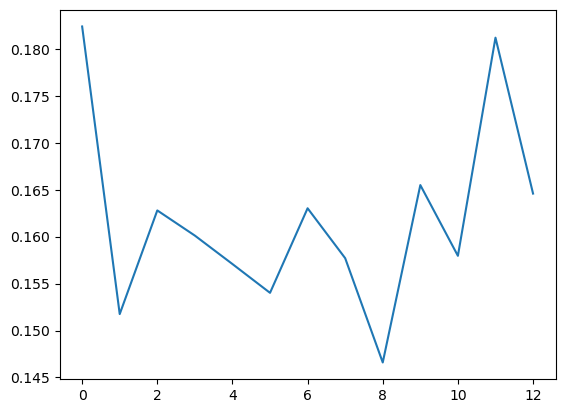

In [31]:
plt.plot(average_loss_all)

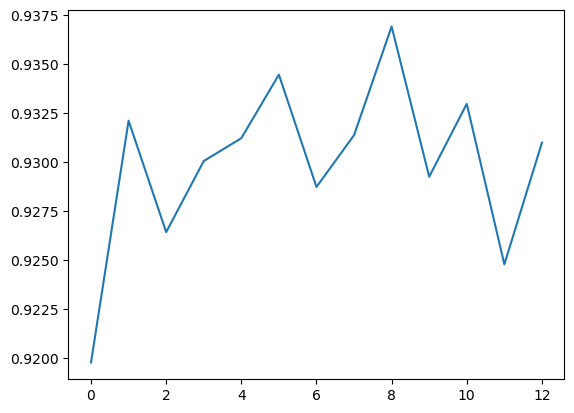

In [32]:
plt.plot(np.array(average_accuracy_all))

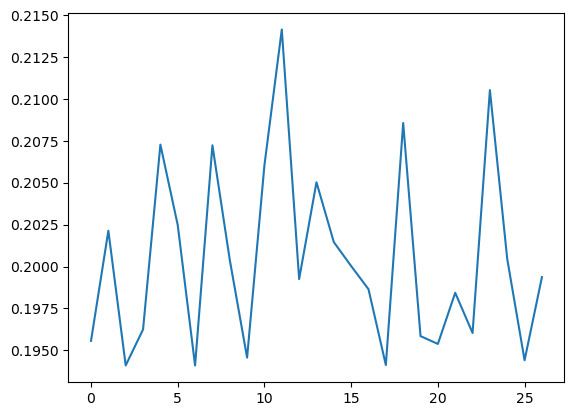

In [26]:
plt.plot(average_loss_all)

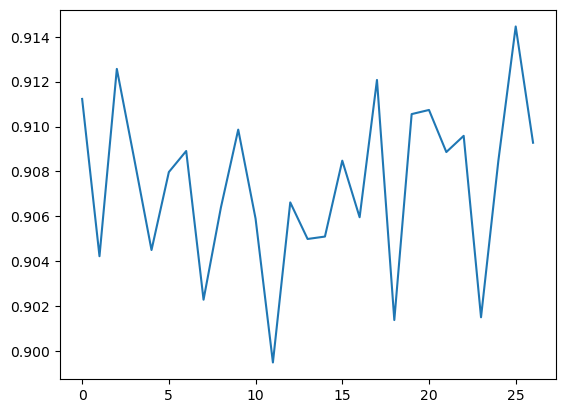

In [28]:
plt.plot(np.array(average_accuracy_all))

In [7]:
bl_model.layers[4].summary()

Model: "sequential_562"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_scale_shift_1124 (ConvS (None, 75, 75, 64)        6592      
_________________________________________________________________
max_pooling2d_843 (MaxPoolin (None, 37, 37, 64)        0         
_________________________________________________________________
conv_scale_shift_1125 (ConvS (None, 37, 37, 64)        413824    
_________________________________________________________________
max_pooling2d_844 (MaxPoolin (None, 18, 18, 64)        0         
_________________________________________________________________
conv_scale_shift_1126 (ConvS (None, 18, 18, 128)       213248    
_________________________________________________________________
max_pooling2d_845 (MaxPoolin (None, 9, 9, 128)         0         
_________________________________________________________________
conv_scale_shift_1127 (ConvS (None, 9, 9, 128)      

In [8]:
mtl_model.layers[4].summary()

Model: "sequential_572"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_scale_shift_1144 (ConvS (None, 75, 75, 64)        6592      
_________________________________________________________________
max_pooling2d_858 (MaxPoolin (None, 37, 37, 64)        0         
_________________________________________________________________
conv_scale_shift_1145 (ConvS (None, 37, 37, 64)        413824    
_________________________________________________________________
max_pooling2d_859 (MaxPoolin (None, 18, 18, 64)        0         
_________________________________________________________________
conv_scale_shift_1146 (ConvS (None, 18, 18, 128)       213248    
_________________________________________________________________
max_pooling2d_860 (MaxPoolin (None, 9, 9, 128)         0         
_________________________________________________________________
conv_scale_shift_1147 (ConvS (None, 9, 9, 128)      

In [11]:
print(best_model.layers[4].get_weights()[5])

[[[[0.9994311  0.9973524  0.9978748  ... 1.0002866  0.9966756
    0.99970204]
   [0.999888   1.0019759  1.0001299  ... 1.0007702  0.9971781
    0.99907136]
   [0.99931765 0.99936014 1.0004208  ... 1.0005143  1.001805
    0.99540085]
   ...
   [1.0011834  0.99809736 1.0017056  ... 1.000118   1.0002946
    1.000435  ]
   [0.99946725 0.9981688  0.99614286 ... 0.99989426 0.997299
    1.0026953 ]
   [0.99856615 0.998517   1.0001339  ... 1.0003668  0.99697995
    1.0015881 ]]]]


In [12]:
print(mtl_model.layers[4].get_weights()[2])

[[[[ 0.06051897 -0.00625105  0.00506146 ... -0.05880547 -0.00956338
    -0.02268306]]

  [[-0.00309567  0.04085363  0.04250082 ... -0.08519962  0.03906929
    -0.01095367]]

  [[ 0.04084228 -0.08691151  0.06347911 ... -0.04012352  0.02766546
     0.0229894 ]]

  [[ 0.08597732 -0.21578102  0.05692383 ... -0.08745253  0.02860547
     0.02172967]]

  [[ 0.0372591  -0.21662705  0.00260276 ... -0.1120059  -0.46663502
    -0.0032398 ]]]


 [[[ 0.07945629  0.05487027  0.07127742 ... -0.06473563  0.0255105
     0.01475979]]

  [[ 0.07074746 -0.01686206  0.09176777 ... -0.0905656   0.06298482
    -0.00614519]]

  [[-0.00946323  0.05567485  0.03018627 ... -0.03779344  0.0326176
     0.01907972]]

  [[-0.07153015  0.01600588  0.0451411  ... -0.03916595  0.04417041
     0.0887928 ]]

  [[-0.01126463 -0.13942723 -0.09822421 ... -0.03706196 -0.36187834
     0.0414549 ]]]


 [[[-0.04201421 -0.04141825  0.04818582 ... -0.06344835 -0.0353003
    -0.05290755]]

  [[-0.006019   -0.01545149  0.08450299 ..

In [10]:
os.chdir('/home/manhducnmd/pp_dijet/Model_results')    
test_model = CWoLA(25, trable = False, conv_trable = False)
test_model.load_weights(f'weights_mtl_dd10_{p_1}')
initial_model = CWoLA(25, trable = False, conv_trable = False)
initial_model.load_weights(f'/home/manhducnmd/pp_dijet/Model_results/weights_pt_dd10_{p_1}')


In [11]:
print(test_model.layers[4].get_weights())

[array([ 1.0288100e-03, -6.6917296e-04, -3.2300509e-03, -4.4228992e-04,
       -1.5400096e-03,  2.6726783e-03, -4.3891405e-04,  3.2858872e-03,
       -2.5953588e-03,  1.5260309e-03, -1.7987353e-03, -2.6453345e-03,
       -2.0224336e-03, -2.9083823e-03, -1.3090099e-03,  2.0106006e-03,
        2.5640875e-03, -1.4459892e-03, -3.0002315e-03,  2.6640627e-03,
       -1.8377497e-03, -2.4628330e-03, -1.3390346e-03, -1.7236659e-03,
       -6.1157753e-04, -1.5215250e-03, -1.9320898e-03, -2.0141680e-04,
       -5.5695465e-04, -2.2967511e-03, -3.2531423e-03, -3.0803215e-03,
        3.1272386e-05, -1.2565338e-03,  2.5270458e-03, -2.5004228e-03,
        3.0400821e-03, -1.5412035e-03, -1.4786550e-05, -1.6160309e-03,
       -3.1027477e-03,  1.1865763e-03, -2.3291777e-03,  2.5426579e-04,
       -2.3803283e-03, -8.2564109e-04, -1.8267024e-03, -2.1404466e-03,
        1.9253303e-03, -4.2604411e-04,  3.3666103e-04,  2.9500267e-03,
        1.6082155e-03, -1.7180553e-03, -1.3181849e-03, -1.5323497e-03,
     

In [12]:
print(initial_model.layers[4].get_weights())

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), array([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1.]]]], dtype=float32), array([[[[ 5.49082235e-02, -1.81777403e-01, -6.04940116e-01, ...,
          -6.49320707e-02, -1.11150660e-01,  4.05093059e-02]],

        [[-9.21174139e-02, -4.41086739e-02, -5.66945136e-01, ...,
           2.34861225e-02,  6.50384128e-02,  1.28547205e-02]],

        [[ 1.23540387e-01, -9.26939249e-01, -4.94111389e-01, ...,
           3.65246646e-02,  8.64241943e-02, -2

In [ ]:
# Fine-tuning on data
n_train_sr_bkg = 50000
n_train_sr_bkg_ft = 25000
mean_results = []
std_results = []
n_test_sr_bkg = 20000
for p_1 in [25, 50]:#[25, 50]:#[25,50,75]:
    rng = np.random.default_rng(seed=42)
    os.chdir('/home/manhducnmd/pp_dijet/Model_results')    
    loaded_model = CWoLA(p_1, trable = False, conv_trable = False)   
    redundant_model = CWoLA(p_1, trable = False, conv_trable = False)
    loaded_model.load_weights(f'weights_mtl_dd10_{p_1}')
    loaded_model.layers[5].set_weights(redundant_model.layers[5].get_weights())    
    
    os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')   
    
    bkg_sr_jet_1 = np.load(f'retest_full_background_images_sr_{p_1}_jet_1.npy')
    bkg_sr_jet_2 = np.load(f'retest_full_background_images_sr_{p_1}_jet_2.npy')
    
    bkg_sb_jet_1 = np.load(f'retest_full_background_images_sb_{p_1}_jet_1.npy')
    bkg_sb_jet_2 = np.load(f'retest_full_background_images_sb_{p_1}_jet_2.npy')
    
    sb_sr_bkg = np.shape(bkg_sb_jet_1)[0]/np.shape(bkg_sr_jet_2)[0]
    n_train_sb_bkg_ft = int(np.round(n_train_sr_bkg_ft*sb_sr_bkg))
    #First jet, background, SR
    bkg_pretrain_sr_1 = bkg_sr_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SR
    bkg_pretrain_sr_2 = bkg_sr_jet_2[0:-n_test_sr_bkg]
    #First jet, background, SB
    bkg_pretrain_sb_1 = bkg_sb_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SB
    bkg_pretrain_sb_2 = bkg_sb_jet_2[0:-n_test_sr_bkg]
    
    signal_sr_jet_1 = np.load(f'm_dd10_sr_{p_1}_jet_1.npy')
    signal_sr_jet_2 = np.load(f'm_dd10_sr_{p_1}_jet_2.npy')
    
    signal_sb_jet_1 = np.load(f'm_dd10_sb_{p_1}_jet_1.npy')
    signal_sb_jet_2 = np.load(f'm_dd10_sb_{p_1}_jet_2.npy')
    
    sb_sr_signal = np.shape(signal_sb_jet_1)[0]/np.shape(signal_sr_jet_1)[0]
    for n_train_sr_signal in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
        significance = np.sqrt(2*((n_train_sr_signal+25000)*np.log(n_train_sr_signal/25000 + 1) - n_train_sr_signal))
        
        n_train_sb_signal = int(np.round(n_train_sr_signal*sb_sr_signal))
        n_test_sr_signal = 20000
        
        #First jet, signal, SR
        signal_pretrain_sr_1 = signal_sr_jet_1[0:20000]
        
        #Second jet, signal, SR
        signal_pretrain_sr_2 = signal_sr_jet_2[0:20000]

        #First jet, signal, SB
        signal_pretrain_sb_1 = signal_sb_jet_1[0:20000]

        #Second jet, signal, SB
        signal_pretrain_sb_2 = signal_sb_jet_2[0:20000]
        
        rng_2 = np.random.default_rng(seed=42)
        rng_3 = np.random.default_rng(seed=42)

        for i in range(10):
            indices_2 = rng_2.permutation(np.shape(bkg_pretrain_sr_1)[0])
            indices_3 = rng_3.permutation(np.shape(signal_pretrain_sr_1)[0])
            
            #First jet, background, SR
            bkg_train_sr_1 = (bkg_pretrain_sr_1[indices_2])[0:n_train_sr_bkg_ft]
            #Second jet, background, SR
            bkg_train_sr_2 = (bkg_pretrain_sr_2[indices_2])[0:n_train_sr_bkg_ft]
            #First jet, background, SB
            bkg_train_sb_1 = (bkg_pretrain_sb_1[indices_2])[0:n_train_sb_bkg_ft]
            #Second jet, background, SB
            bkg_train_sb_2 = (bkg_pretrain_sb_2[indices_2])[0:n_train_sb_bkg_ft]

            signal_train_sr_1 = (signal_pretrain_sr_1[indices_3])[0:n_train_sr_signal]
            #Second jet, background, SR
            signal_train_sr_2 = (signal_pretrain_sr_2[indices_3])[0:n_train_sr_signal]
            #First jet, background, SB
            signal_train_sb_1 = (signal_pretrain_sb_1[indices_3])[0:n_train_sb_signal]
            #Second jet, background, SB
            signal_train_sb_2 = (signal_pretrain_sb_2[indices_3])[0:n_train_sb_signal]

            train_sr_1 = np.concatenate((signal_train_sr_1, bkg_train_sr_1))
            train_sr_2 = np.concatenate((signal_train_sr_2, bkg_train_sr_2))
            train_label_sr = np.ones(np.shape(train_sr_1)[0], dtype = int)

            train_sb_1 = np.concatenate((signal_train_sb_1, bkg_train_sb_1))
            train_sb_2 = np.concatenate((signal_train_sb_2, bkg_train_sb_2))
            train_label_sb = np.zeros(np.shape(train_sb_1)[0], dtype = int)

            x_train_1 = np.concatenate((train_sr_1, train_sb_1))
            x_train_2 = np.concatenate((train_sr_2, train_sb_2))
            y_train = np.concatenate((train_label_sr, train_label_sb))

            #Mix up the samples
            indices = rng.permutation(np.shape(y_train)[0])
            x_train_1 = x_train_1[indices]
            x_train_2 = x_train_2[indices]
            y_train = y_train[indices]

            x_train_1 = x_train_1.reshape((np.shape(x_train_1)[0], p_1, p_1, 1))
            x_train_2 = x_train_2.reshape((np.shape(x_train_2)[0], p_1, p_1, 1))

            print(f'Training with significance = {significance:.2f}, run {i}')
            cwola_ft = CWoLA(p_1, trable = True, conv_trable = False)
            cwola_ft.set_weights(loaded_model.get_weights())
            cwola_ft.trainable = True
            cwola_ft.layers[4].trainable = False #Freezing the 4th layer            
            loss_object = keras.losses.BinaryCrossentropy()
            optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
            cwola_ft.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
            early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
            history = cwola_ft.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
              shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
            cwola_ft.save_weights(f'/home/manhducnmd/pp_dijet/Model_results/run_{i}_weights_mtl_dd10_{n_train_sr_signal}_{p_1}')            


2024-08-09 18:26:27.088375: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-08-09 18:26:27.120691: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3200000000 Hz
2024-08-09 18:26:27.123257: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f369dc4e50 executing computations on platform Host. Devices:
2024-08-09 18:26:27.123300: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2024-08-09 18:26:27.124976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:d8:00.0
2024-08-09 18:26:27.125093: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-08-09 18:26:27.125124: I tenso

Training with significance = 0.32, run 0
Train on 40903 samples, validate on 10226 samples
Epoch 1/1000


2024-08-09 18:26:33.426808: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-08-09 18:26:33.797007: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-08-09 18:26:34.619226: W tensorflow/stream_executor/cuda/redzone_allocator.cc:312] Not found: ./bin/ptxas not found
Relying on driver to perform ptx compilation. This message will be only logged once.


40903/40903 [==============================] - 8s 191us/sample - loss: 0.7195 - accuracy: 0.5144 - val_loss: 0.6944 - val_accuracy: 0.5144
Epoch 2/1000
40903/40903 [==============================] - 4s 97us/sample - loss: 0.6930 - accuracy: 0.5163 - val_loss: 0.6924 - val_accuracy: 0.5193
Epoch 3/1000
40903/40903 [==============================] - 4s 100us/sample - loss: 0.6920 - accuracy: 0.5196 - val_loss: 0.6921 - val_accuracy: 0.5164
Epoch 4/1000
40903/40903 [==============================] - 4s 98us/sample - loss: 0.6918 - accuracy: 0.5180 - val_loss: 0.6920 - val_accuracy: 0.5184
Epoch 5/1000
40903/40903 [==============================] - 4s 97us/sample - loss: 0.6916 - accuracy: 0.5186 - val_loss: 0.6919 - val_accuracy: 0.5152
Epoch 6/1000
40903/40903 [==============================] - 4s 96us/sample - loss: 0.6913 - accuracy: 0.5193 - val_loss: 0.6920 - val_accuracy: 0.5192
Epoch 7/1000
40903/40903 [==============================] - 4s 98us/sample - loss: 0.6911 - accuracy: 0.5

In [14]:
cwola_ft.layers[4].summary()

Model: "sequential_1464"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_scale_shift_2928 (ConvS (None, 25, 25, 64)        1792      
_________________________________________________________________
max_pooling2d_2196 (MaxPooli (None, 12, 12, 64)        0         
_________________________________________________________________
conv_scale_shift_2929 (ConvS (None, 12, 12, 64)        106624    
_________________________________________________________________
max_pooling2d_2197 (MaxPooli (None, 6, 6, 64)          0         
_________________________________________________________________
conv_scale_shift_2930 (ConvS (None, 6, 6, 128)         82176     
_________________________________________________________________
max_pooling2d_2198 (MaxPooli (None, 3, 3, 128)         0         
_________________________________________________________________
conv_scale_shift_2931 (ConvS (None, 3, 3, 128)     

In [50]:
print(cwola_ft.layers[4].get_weights()[5])

[[[[0.99932915 0.9950673  0.9981851  ... 1.0010327  0.9979877
    0.99696356]
   [1.0038584  0.9969417  1.0017126  ... 1.0036842  1.0003309
    1.0011826 ]
   [0.9992418  0.99741185 1.0015494  ... 0.9972702  0.99600667
    1.0007223 ]
   ...
   [1.000572   0.99909294 0.9994549  ... 1.0075109  1.0015382
    0.9972356 ]
   [0.99525434 0.998876   0.9999134  ... 0.9940463  0.9988904
    1.0005013 ]
   [0.99702626 0.9993795  0.99777156 ... 1.0037167  1.0007213
    0.99378645]]]]


In [8]:
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

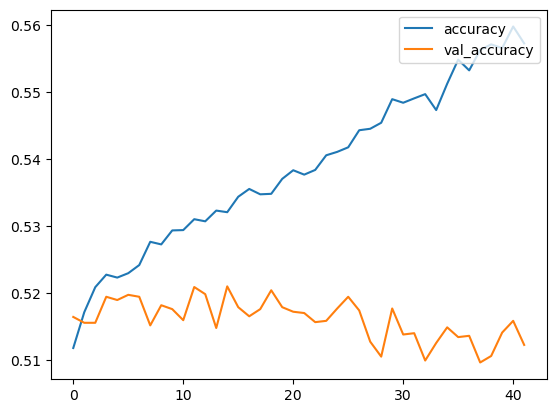

In [36]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [26]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [27]:
bkg_sr_jet_1 = np.load('retest_full_background_images_sr_25_jet_1.npy')
bkg_sr_jet_2 = np.load('retest_full_background_images_sr_25_jet_2.npy')

signal_sr_jet_1 = np.load('m_dd10_sr_25_jet_1.npy')
signal_sr_jet_2 = np.load('m_dd10_sr_25_jet_2.npy')



In [28]:
signal_test_1 = signal_sr_jet_1[-20000:]
signal_test_2 = signal_sr_jet_2[-20000:]

bkg_test_1 = bkg_sr_jet_1[-20000:]
bkg_test_2 = bkg_sr_jet_2[-20000:]


test_label_signal = np.ones(np.shape(signal_test_1)[0])
test_label_bkg = np.zeros(np.shape(bkg_test_1)[0])

x_test_1 = np.concatenate((signal_test_1, bkg_test_1))
x_test_2 = np.concatenate((signal_test_2, bkg_test_2))
y_test = np.concatenate((test_label_signal, test_label_bkg))

x_test_1 = x_test_1.reshape((np.shape(x_test_1)[0],25,25,1))
x_test_2 = x_test_2.reshape((np.shape(x_test_2)[0],25,25,1))


In [29]:
x_predict = cwola_ft.predict([x_test_1, x_test_2])


In [30]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]

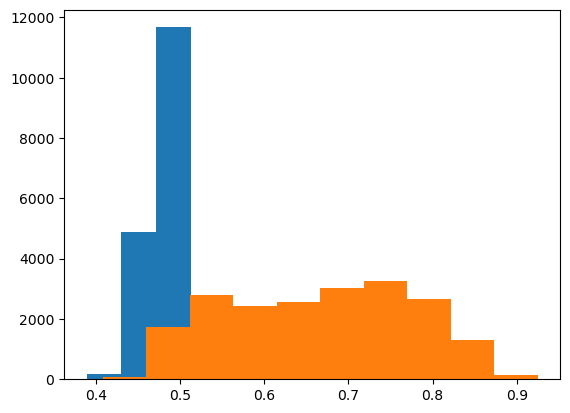

In [31]:
plt.hist(x_predict_0)
plt.hist(x_predict_1)
plt.show()

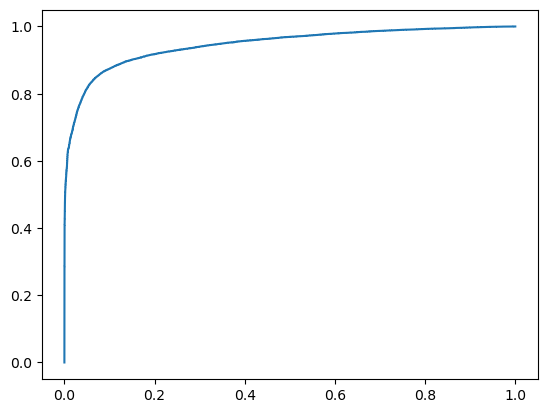

0.9460742575000001


In [32]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))

In [33]:
print(epsilon_s)

[0.4519  0.64175 0.8744 ]


In [34]:
n_train_sr_signal = 900

In [35]:
print(np.sqrt(2*((n_train_sr_signal*epsilon_s[0]+25000*0.001)*np.log(n_train_sr_signal*epsilon_s[0]/(25000*0.001) + 1) - 
                 n_train_sr_signal*epsilon_s[0])))

40.575342899518795


In [36]:
print(np.sqrt(2*((n_train_sr_signal*epsilon_s[1]+25000*0.01)*np.log(n_train_sr_signal*epsilon_s[1]/(25000*0.01) + 1) - 
                 n_train_sr_signal*epsilon_s[1])))

28.742456444509646


In [37]:
print(np.sqrt(2*((n_train_sr_signal*epsilon_s[2]+25000*0.1)*np.log(n_train_sr_signal*epsilon_s[2]/(25000*0.1) + 1) - 
                 n_train_sr_signal*epsilon_s[2])))

15.006012848890178
